In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
"""Los dataset que voy a utilizar son tres (selecciones, partidos y copa). Estos corresponden a datos estadísticos de 
selecciones de fútbol sudamericanas y dos selecciones invitadas no pertenecientes a la CONMEBOL que participaron en 
la Copa América 2019. Estas estadísticas principalmente son: su ranking en la FIFA, las estadísticas de sus jugadores y 
los resultados obtenidos en los últimos partidos disputados entre ellos. 
Estos dataset fueron obtenidos mediante Kaggle.com. El objetivo es predecir la clasificatoria al Mundial de Fútbol
de las selecciones sudamericanas en base a esta información. Para esto, se desarrollará un modelo de predicción basado en 
una regresión logística y las variables a utilizar para este modelo serán: su ranking en la FIFA, la estadística de sus 
jugadores y los resultados obtenidos en sus últimos partidos. Finalmente, la predicción se realizará en los partidos en 
la modalidad todos contra todos y se armará en base a sus resultados una tabla de posiciones con los puntos obtenidos en sus
respectivos partidos."""

In [3]:
equipos = pd.read_csv('./selecciones.csv') #Cargo mi dataset selecciones.csv
equipos.columns.values #Muestro los nombres de las columnas de mi fichero selecciones.csv
#Al tratarse de un dataset de los equipos que participaban en la Copa América Brasil 2019, es necesario filtrar las filas
#que contengan información de Japón y Qatar ya que no son equipos sudamericanos.
#Para esto eliminamos las filas que contengan el valor Japon o Qatar de la columna seleccion.
equipos = equipos.drop(equipos[equipos['seleccion'] == "Japon"].index)
equipos = equipos.drop(equipos[equipos['seleccion'] == "Qatar"].index)
equipos['seleccion'] #Imprimo la columna seleccion para verificar que ya no exista valores de Japon y Qatar

0      Argentina
1      Argentina
2      Argentina
3      Argentina
4      Argentina
         ...    
269    Venezuela
270    Venezuela
271    Venezuela
272    Venezuela
273    Venezuela
Name: seleccion, Length: 230, dtype: object

In [4]:
partidos = pd.read_csv('./partidos.csv') ##Cargo mi dataset partidos.csv
partidos.columns.values #Muestro los nombres de las columnas de mi fichero partidos.csv
#Al tratarse de un dataset de los equipos que participaban en la Copa América Brasil 2019, es necesario filtrar las filas
#que contengan información de Japón y Qatar ya que no son equipos sudamericanos.
#Para esto eliminamos las filas que contengan el valor Japon o Qatar de las columnas local y visitante.
partidos = partidos.drop(partidos[partidos['local'] == "Japon"].index)
partidos = partidos.drop(partidos[partidos['local'] == "Qatar"].index)
partidos = partidos.drop(partidos[partidos['visitante'] == "Japon"].index)
partidos = partidos.drop(partidos[partidos['visitante'] == "Qatar"].index)
partidos['local'] #Imprimo la columna local para verificar que ya no exista valores de Japon y Qatar
partidos['visitante'] #Imprimo la columna visitante para verificar que ya no exista valores de Japon y Qatar

0        Uruguay
1      Venezuela
2      Argentina
3       Colombia
4        Ecuador
         ...    
907        Chile
908    Argentina
909    Venezuela
910     Colombia
911      Bolivia
Name: visitante, Length: 856, dtype: object

In [5]:
equipos['Overall'] = equipos['Overall'].fillna(65) #Completo la columna Overall con valor null y asigno el valor 65
equipos['Overall'] #Imprimo la columna Overall para verificar que se hayan llenado los datos con valor null

0      80.0
1      72.0
2      80.0
3      74.0
4      80.0
       ... 
269    65.0
270    62.0
271    67.0
272    69.0
273    77.0
Name: Overall, Length: 230, dtype: float64

In [6]:
potencial = equipos.groupby('seleccion').mean()['Overall'] #Creo una columna con el valor del potencial promedio del equipo en base a sus jugadores
partidos = partidos.merge(potencial, left_on=['local'], right_on=['seleccion']) #Agrego el valor del potencial de cada selección al dataset partidos en base al valor de la columna local
partidos = partidos.merge(potencial, left_on=['visitante'], right_on=['seleccion'], suffixes=('_local', '_visitante')) #Agrego el valor del potencial de cada selección al dataset partidos en base al valor de la columna visitante
partidos['dif_potencial'] = partidos['Overall_local'] - partidos['Overall_visitante'] #Agrego una columna con el valor de la diferencia de potencial entre los equipos

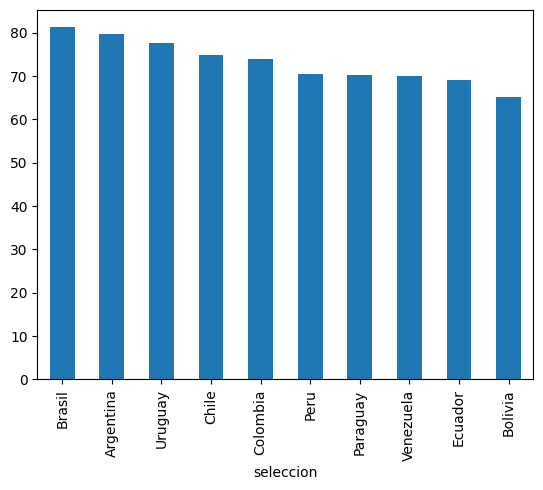

In [7]:
plot = potencial.sort_values( ascending=False).plot(kind='bar') #Obtengo la gráfica del potencial de cada seleccióm

In [9]:
x, y = partidos.loc[:,['ranking_local', 'dif_ranking', 'dif_potencial']], partidos['gana_local'] #Se va a utilizar un modelo de regresión logística para la predicción de resultados y los datos para entrenar el modelo serán su ranking local y FIFA, y el potencial de los jugadores de las selecciones.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

logreg = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([('polynomial_features', features), ('logistic_regression', logreg)])
model = model.fit(x_train, y_train)

c:\Users\Alexander Dueñas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


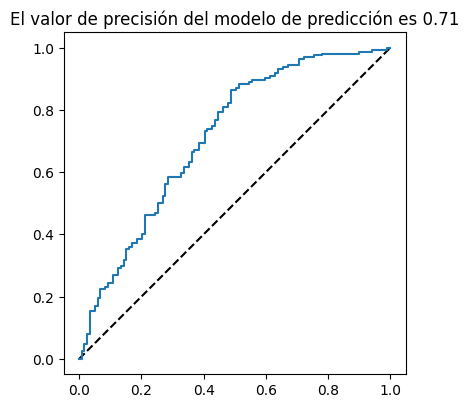

In [10]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1]) #Mediante esta gráfica obtenemos el valor de precisión de nuestro modelo (En nuestro caso es del 71%)
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('El valor de precisión del modelo de predicción es {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(x_test)[:,1])))
ax.set_aspect(1)

In [11]:
copa = pd.read_csv('./copa.csv') #Cargo mi dataset copa.csv
copa.columns.values #Muestro los nombres de las columnas de mi fichero copa.csv
#Al tratarse de un dataset de los equipos que participaban en la Copa América Brasil 2019, es necesario filtrar las filas
#que contengan información de Japón y Qatar ya que no son equipos sudamericanos.
#Para esto eliminamos las filas que contengan el valor Japon o Qatar de la columna equipo.
copa = copa.drop(copa[copa['equipo'] == "Japon"].index)
copa = copa.drop(copa[copa['equipo'] == "Qatar"].index)
copa['equipo'] #Imprimo la columna equipo para verificar que ya no exista valores de Japon y Qatar

0        Brasil
1       Bolivia
2     Venezuela
3          Peru
4     Argentina
5      Colombia
6      Paraguay
8       Uruguay
9       Ecuador
11        Chile
Name: equipo, dtype: object

In [12]:
copa = copa.merge(potencial, left_on=['equipo'], right_on=['seleccion']) #Agrego el valor del potencial de cada selección al dataset copa en base al valor de la columna equipo
copa = copa.set_index(['equipo']) #Fijamos como índice del dataframe la columna equipo

In [13]:
#Simulamos la eliminatoria sudamericana, todos contra todos
from itertools import combinations

margin = 0.05 #Establecemos el margen de error para definir un empate entre dos selecciones

copa['puntos'] = 0 #Agregamos la columna puntos que contiene el valor acumulado de puntos obtenidos por cada partido
copa['grupo'] = "A" #Asignamos el valor de A en la columna grupo de las selecciones para que se enfrenten todos contra todos

for grupo in sorted(set(copa['grupo'])):
    print("--- Predicción de los partidos de la Eliminatoria Sudamericana ---")
    for local, visitante in combinations(copa.query('grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(local, visitante), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=x_test.columns)
        row['ranking_local'] = copa.loc[local, 'ranking FIFA']
        opp_rank = copa.loc[visitante, 'ranking FIFA']
        local_pot = copa.loc[local, 'Overall']
        opp_pot = copa.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['dif_potencial'] = local_pot - opp_pot  
        local_win_prob = model.predict_proba(row)[:,1][0]
        # Asignamos los puntos en base al resultado de los partidos de cada selección
        puntos = 0
        if local_win_prob <= 0.5 - margin:
            print("{} gana con prob de {:.3f}".format(visitante, 1-local_win_prob))
            copa.loc[visitante, 'puntos'] += 3
        if local_win_prob > 0.5 - margin:
            puntos = 1
        if local_win_prob >= 0.5 + margin:
            puntos = 3
            copa.loc[local, 'puntos'] += 3
            print("{} gana con prob de {:.3f}".format(local, local_win_prob))
        if puntos == 1:
            print("empatan")
            copa.loc[local, 'puntos'] += 1
            copa.loc[visitante, 'puntos'] += 1

--- Predicción de los partidos de la Eliminatoria Sudamericana ---
Brasil vs. Bolivia: Brasil gana con prob de 0.759
Brasil vs. Venezuela: Brasil gana con prob de 0.602
Brasil vs. Peru: Brasil gana con prob de 0.576
Brasil vs. Argentina: empatan
Brasil vs. Colombia: empatan
Brasil vs. Paraguay: Brasil gana con prob de 0.620
Brasil vs. Uruguay: empatan
Brasil vs. Ecuador: Brasil gana con prob de 0.704
Brasil vs. Chile: empatan
Bolivia vs. Venezuela: Venezuela gana con prob de 0.616
Bolivia vs. Peru: Peru gana con prob de 0.640
Bolivia vs. Argentina: Argentina gana con prob de 0.699
Bolivia vs. Colombia: Colombia gana con prob de 0.678
Bolivia vs. Paraguay: Paraguay gana con prob de 0.599
Bolivia vs. Uruguay: Uruguay gana con prob de 0.699
Bolivia vs. Ecuador: empatan
Bolivia vs. Chile: Chile gana con prob de 0.678
Venezuela vs. Peru: empatan
Venezuela vs. Argentina: Argentina gana con prob de 0.571
Venezuela vs. Colombia: Colombia gana con prob de 0.559
Venezuela vs. Paraguay: empatan
V

In [14]:
#Permite visualizar la tabla de posiciones de la eliminatoria
copa = copa.sort_values('puntos', ascending = False).reset_index()
tablaClasificacion = copa.groupby('grupo').nth([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).reset_index()
tablaClasificacion['posicion'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tablaClasificacion[['posicion', 'equipo', 'puntos']]

,posicion,equipo,puntos
0,1,Brasil,19
1,2,Argentina,17
2,3,Colombia,17
3,4,Uruguay,17
4,5,Chile,17
5,6,Peru,12
6,7,Venezuela,8
7,8,Paraguay,8
8,9,Bolivia,1
9,10,Ecuador,1


In [15]:
#Agrupamos los 5 mejores clasificados que irían al Mundial
clasificados = copa.groupby('grupo').nth([0, 1, 2, 3, 4]).reset_index()
clasificados[['equipo', 'puntos']]

,equipo,puntos
0,Brasil,19
1,Argentina,17
2,Colombia,17
3,Uruguay,17
4,Chile,17
